In [7]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from src.dataset import BreathingAudioDataset

In [8]:
dataframe = pd.read_csv("../input/train.csv")

train_dataframe, validation_dataframe = train_test_split(
    dataframe, test_size=0.2, stratify=dataframe["Target"], random_state=42
)

train_dataset = BreathingAudioDataset(
    train_dataframe,
    "../input/train",
    is_training=True,
)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 3200/3200 [00:11<00:00, 272.73it/s]


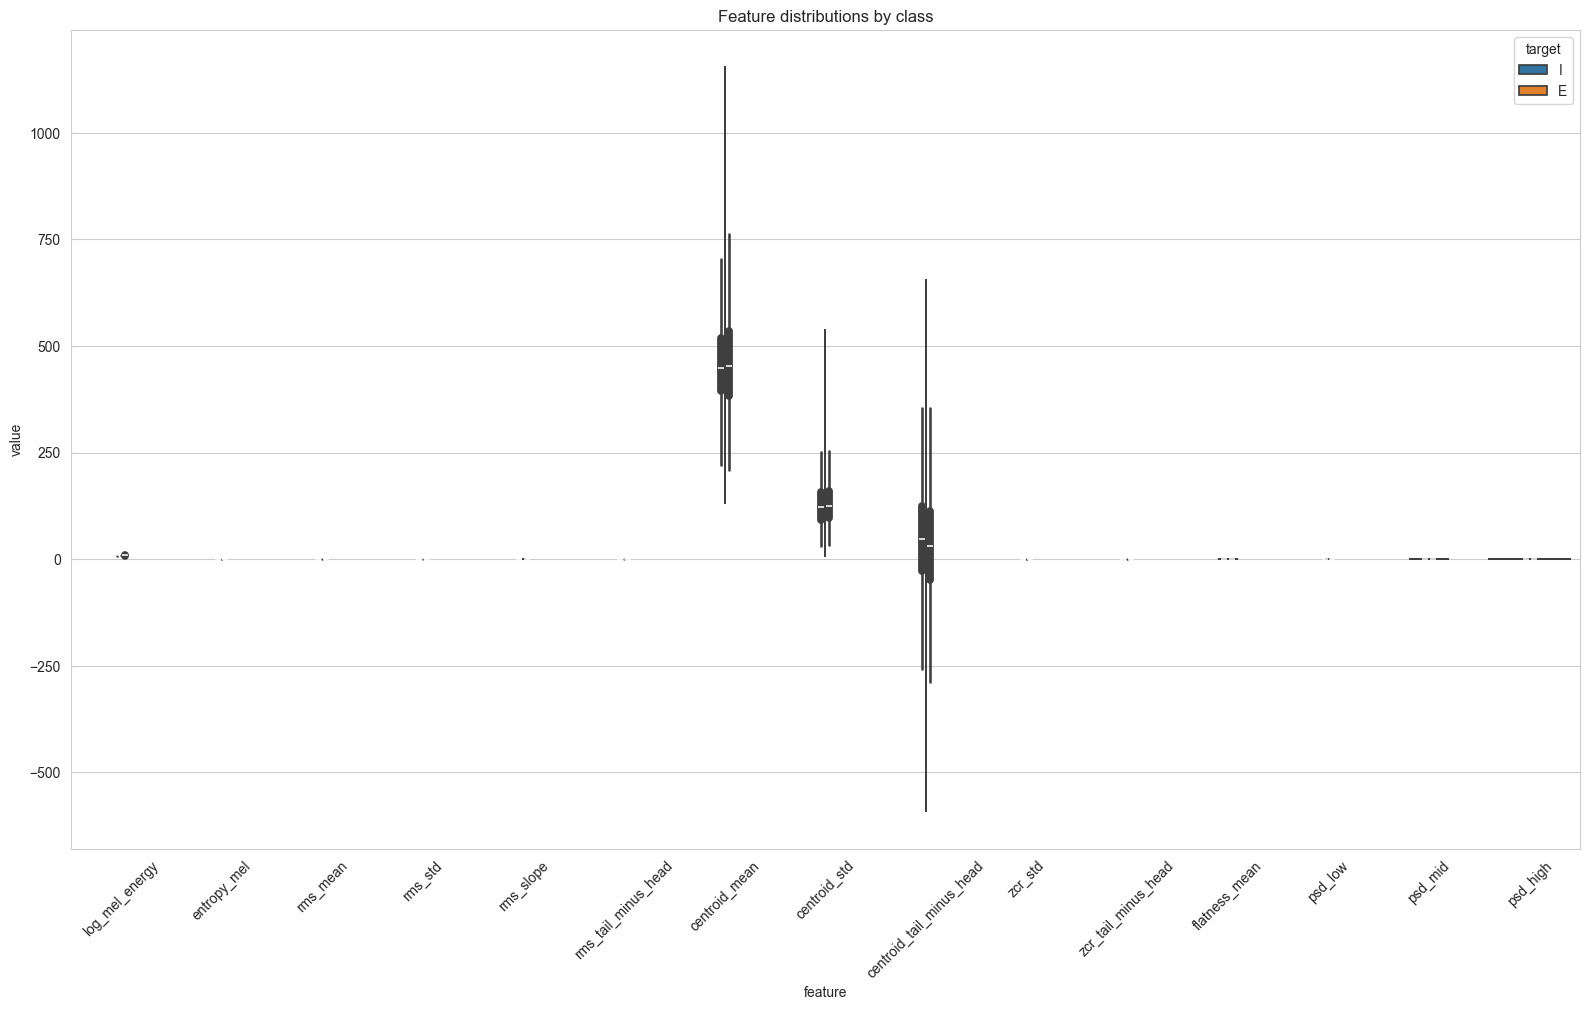

In [9]:
def extract_scalar_features(dataset):
    data = []
    labels = []
    for item in tqdm(dataset):
        x, label = item
        scalars = x['scalars'].numpy()
        data.append(scalars)
        labels.append(label.item())
    return pd.DataFrame(data), labels

# Assuming you have a loaded training dataset
df, labels = extract_scalar_features(train_dataset)
df.columns = [
    "log_mel_energy", "entropy_mel",
    "rms_mean", "rms_std", "rms_slope", "rms_tail_minus_head",
    "centroid_mean", "centroid_std", "centroid_tail_minus_head",
    "zcr_std", "zcr_tail_minus_head",
    "flatness_mean", "psd_low", "psd_mid", "psd_high"
]
df["target"] = ["E" if y > 0.5 else "I" for y in labels]

# Plot violin plots
plt.figure(figsize=(16, 10))
melted = df.melt(id_vars=["target"], var_name="feature", value_name="value")
sns.violinplot(data=melted, x="feature", y="value", hue="target", split=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("Feature distributions by class")
plt.show()

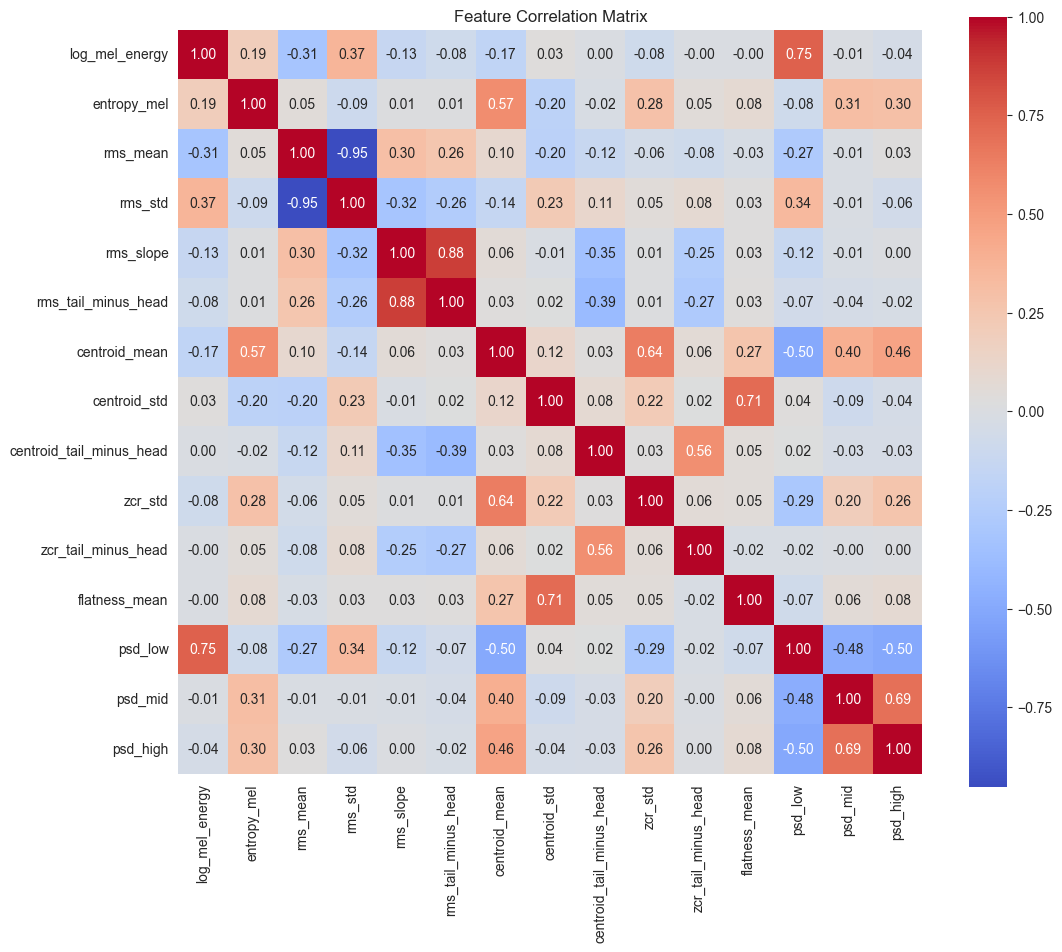

                          log_mel_energy  entropy_mel  rms_mean   rms_std  \
log_mel_energy                  1.000000     0.194897 -0.311972  0.366684   
entropy_mel                     0.194897     1.000000  0.054511 -0.092963   
rms_mean                       -0.311972     0.054511  1.000000 -0.951436   
rms_std                         0.366684    -0.092963 -0.951436  1.000000   
rms_slope                      -0.133418     0.011819  0.303619 -0.315491   
rms_tail_minus_head            -0.077487     0.012744  0.255420 -0.255448   
centroid_mean                  -0.167708     0.565541  0.096590 -0.142128   
centroid_std                    0.033587    -0.195941 -0.199659  0.229547   
centroid_tail_minus_head        0.000909    -0.016982 -0.123416  0.114981   
zcr_std                        -0.075363     0.283988 -0.059018  0.050962   
zcr_tail_minus_head            -0.000090     0.049695 -0.078640  0.080451   
flatness_mean                  -0.004730     0.079133 -0.028494  0.026477   

In [13]:
plt.figure(figsize=(12, 10))
corr = df.drop(columns="target").corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()
print(corr)

In [11]:
for col in df.columns[:-1]:
    auc = roc_auc_score([1 if t == "E" else 0 for t in df["target"]], df[col])
    print(f"{col:<25}: {auc:.4f}")

log_mel_energy           : 0.4259
entropy_mel              : 0.3868
rms_mean                 : 0.4957
rms_std                  : 0.4993
rms_slope                : 0.5269
rms_tail_minus_head      : 0.4757
centroid_mean            : 0.5039
centroid_std             : 0.5162
centroid_tail_minus_head : 0.4599
zcr_std                  : 0.5336
zcr_tail_minus_head      : 0.4624
flatness_mean            : 0.4894
psd_low                  : 0.4400
psd_mid                  : 0.4702
psd_high                 : 0.4910


In [12]:
grouped_stats = df.groupby("target").describe().T
pd.set_option("display.max_rows", None)
print("\nðŸ“Š Descriptive Statistics by Class (E vs I):\n")
print(grouped_stats.round(4))


ðŸ“Š Descriptive Statistics by Class (E vs I):

target                                  E          I
log_mel_energy           count  1600.0000  1600.0000
                         mean      8.5083     8.5238
                         std       0.0740     0.0680
                         min       8.1400     7.6371
                         25%       8.4828     8.5092
                         50%       8.5367     8.5501
                         75%       8.5609     8.5648
                         max       8.5747     8.5746
entropy_mel              count  1600.0000  1600.0000
                         mean     -0.2121    -0.1833
                         std       0.0738     0.0612
                         min      -0.5278    -0.5883
                         25%      -0.2557    -0.2213
                         50%      -0.2025    -0.1743
                         75%      -0.1567    -0.1377
                         max      -0.0464    -0.0486
rms_mean                 count  1600.0000  1600.00